In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())
import pickle
from testsuite.utilities import Pareto_split
import numpy as np
from testsuite.analysis import load_all, plot_all_pareto_3d, PLOT_STYLE, plot_measure
import matplotlib.pyplot as plt

In [2]:
dir_path = os.getcwd()
result_dirs = sorted(os.listdir("./log_data/"))
result_dirs

['test_function_Saf_init10_MultiSurrogate_ei',
 'test_function_Saf_init10_MultiSurrogate_mean',
 'test_function_SmsEgo_init10_MultiSurrogate_ei',
 'test_function_SmsEgo_init10_MultiSurrogate_mean']

In [3]:
try:
    pkl_dirs = sorted(os.listdir("./pkl_data/"))
    results = [pickle.load(open("./pkl_data/"+path, "rb")) for path in pkl_dirs]
    loaded=True
except FileNotFound:
    loaded=False
    results = [(result_dir, load_all(os.path.join(dir_path, "log_data/", result_dir))) for result_dir in result_dirs]  
loaded

True

In [9]:
names = ["saf_ei_results",
         "saf_mu_results",
         "sms_ei_results",
         "sms_mu_results"]

for result in results:
    assert(len(result["y"]) == len(results[0]["y"]))

TypeError: tuple indices must be integers or slices, not str

In [10]:
import wfg
N= 500

n_obj = 3                                   # Number of objectives
kfactor = 1
lfactor = 2

k = kfactor*(n_obj-1)   # position related params
l = lfactor*2           # distance related params
n_dim = k+l

func = wfg.WFG4

x_limits = np.zeros((2, n_dim))
x_limits[1] = np.array(range(1,n_dim+1))*2

args = [k, n_obj] # number of objectives as argument

def test_function(x):
    if x.ndim<2:
        x = x.reshape(1, -1)
    return np.array([func(xi, k, n_obj) for xi in x])/(np.array(range(1, n_obj+1))*2)

In [11]:
def scatter_nsphere(n_points, n_dims, weighting=None):
    """scatter n_points onto unit n-spere with n_dims dimensions"""
    if weighting is None:
        weighting = np.ones(n_dims)
    else:
        weighting = np.array(weighting)
    points = np.random.randn(n_points,n_dims)*weighting
    d = (points**2).sum(axis=1)**0.5
    norm_points = (points.T/d.T).T
    return np.abs(norm_points)

In [12]:
y = scatter_nsphere(500, n_obj, (np.array(range(1, n_obj+1))*2))

In [13]:
from pymoo.factory import get_performance_indicator

In [14]:
def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        p = Pareto_split(z[:i])[0]
        ans = indicator.calc(p)
        ANS.append(ans)

    return ANS

In [15]:
import lhsmdu
lhs_x =np.array(lhsmdu.sample(numDimensions=n_dim, numSamples=100)).T*x_limits[1]
lhs_y = np.array([func(z, k, n_obj) for z in lhs_x])/(np.array(range(1, n_obj+1))*2)

In [16]:
ref = np.ones(n_obj)*1.2
ref

array([1.2, 1.2, 1.2])

In [17]:
igdp = get_performance_indicator("igd+", y)
hv = get_performance_indicator("hv", ref_point=ref)

In [ ]:
lhs_x = []
lhs_y = []
lhs_hyp = []
lhs_igd = []
for seed in range(10):
    xs = []
    ys = []
    hyps = []
    igds = []
    for i in range(10, 100):
        x = np.array(lhsmdu.sample(numDimensions=n_dim, numSamples=i)).T*x_limits[1]
        xs.append(x)
        y = test_function(x)
        ys.append(y)
        hyps.append(hv.calc(y))
        igds.append(igdp.calc(y))
    lhs_x.append(xs)  
    lhs_y.append(ys) 
    lhs_hyp.append(hyps)
    lhs_igd.append(igds)

In [18]:
lhslhs_results = {"y": lhs_y,
                 "x": lhs_x}

lhslhs_results["n_initial"] = results[0][1]['n_initial'][0]
lhslhs_results["hypervolume"] = lhs_hyp 
lhslhs_results["igd"] = lhs_igd 

# print(lhslhs_results['hypervolume'])
# print(lhslhs_results['igd'])
# print(lhslhs_results['n_initial'])

ref_hv = hv.calc(np.zeros_like(ref))
print(ref_hv)

KeyError: 1

In [17]:
if not loaded:
    for result in results:
        print(result[0])
        result[1]['igd'] = [extract_performance(result[1]["y"][i], igdp) for i in range(len(result[1]["y"]))]
        result[1]['hypervolume'] = [extract_performance(result[1]["y"][i], hv)/ref_hv for i in range(len(result[1]["y"]))]

In [ ]:
lhs_h

In [ ]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

for i, result in enumerate(results):
    print(result[0], "\t", names[i])
    plot_measure(result[1], measure="hypervolume", axis=ax_hv, plot_individuals=False, label=names[i], color=colors[i])
# ax_hv.axhline(lhs_results["hypervolume"]/ref_hv, linewidth=1, color="b", label="lhs")
ax_hv.plot(range(10, 100), np.mean(lhs_hyp, axis=0)/ref_hv)
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

test_function_Saf_init10_MultiSurrogate_ei 	 saf_ei_results
test_function_Saf_init10_MultiSurrogate_mean 	 saf_mu_results
test_function_SmsEgo_init10_MultiSurrogate_ei 	 sms_ei_results
test_function_SmsEgo_init10_MultiSurrogate_mean 	 sms_mu_results


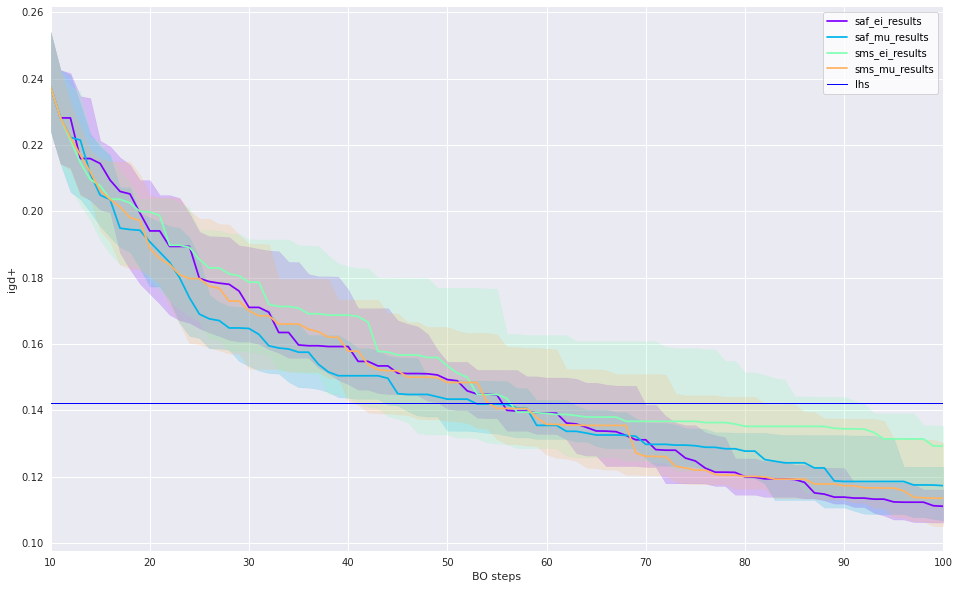

In [19]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_igd = plt.figure(figsize=[16, 10])
    ax_igd = fig_igd.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

for i, result in enumerate(results):
    print(result[0], "\t", names[i])
    plot_measure(result[1], measure="igd", axis=ax_igd, plot_individuals=False, label=names[i], color=colors[i])
ax_igd.axhline(lhslhs_results["igd"], linewidth=1, color="b", label="lhs")
ax_igd.set_xlim([10, 100])
ax_igd.set_xlabel("BO steps")
ax_igd.set_ylabel("igd+")
ax_igd.legend()

In [20]:
[result["errors"] for result in results]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
try:
    for result, name in zip(results, names):
        pickle.dump(result, open("./pkl_data/"+name+".pkl", "wb"))
except FileNotFoundError:
    os.mkdir("./pkl_data")
    for result, name in zip(results, names):
        pickle.dump(result, open("./pkl_data/"+name+".pkl", "wb"))

In [19]:
sms_ei_results["y"][0].max(axis=0)

array([1.06477995, 0.81151601, 0.8917829 , 1.00316199, 1.05041701])

In [32]:
# pickle.dump(lhslhs_results, open("./pkl_data/"+"lhs"+".pkl", "wb"))